In [56]:
import sys
import parselmouth 
import shap

#%pip install pycaret[full]
import pycaret
pycaret.__version__

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from plotly import express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pycaret.datasets import get_data
from pycaret.classification import *
from pycaret.utils import enable_colab
enable_colab()

import scikitplot as skplt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import dash
from dash import dcc
from dash import html

SyntaxError: invalid syntax (3716706603.py, line 24)

open and read in the audio file and plot the raw waveform

In [2]:
sns.set() # Use seaborn's default style to make attractive graphs
plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this notebook
snd = parselmouth.Sound("C:/Users/loo/Downloads/The Leopard IO  copy.wav") 

snd is now a Parselmouth Sound object, and we can access its values and other properties to plot them with the common matplotlib Python library:

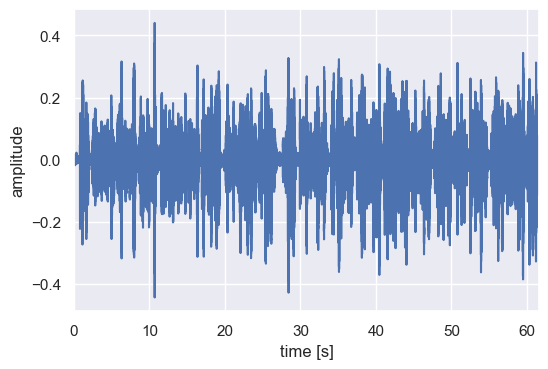

In [5]:
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

It is also possible to extract part of the speech fragment and plot it separately with a finer line.

In [6]:
snd_part = snd.extract_part(from_time=0.9, preserve_times=True)

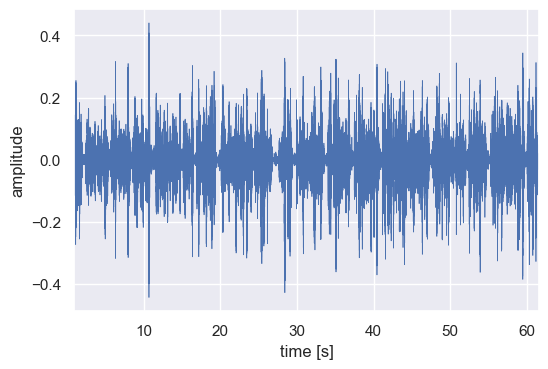

In [7]:
plt.figure()
plt.plot(snd_part.xs(), snd_part.values.T, linewidth=0.5)
plt.xlim([snd_part.xmin, snd_part.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

Next, we can write a couple of ordinary Python functions to plot a Parselmouth Spectrogram and Intensity.

In [8]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")
def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

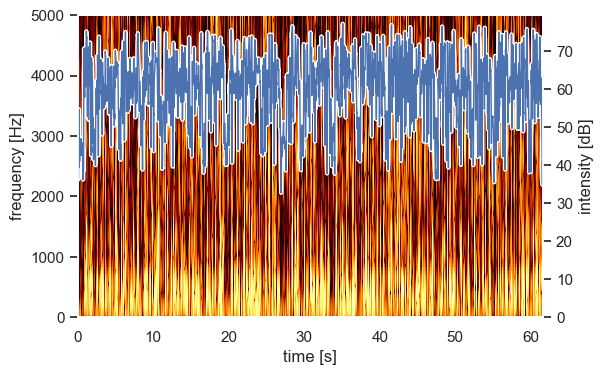

In [9]:
intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show()


The Parselmouth functions and methods have the same arguments as the Praat commands, so we can for example also change the window size of the spectrogram analysis to get a narrow-band spectrogram. Next to that, let’s now have
Praat calculate the pitch of the fragment, so we can plot it instead of the intensity

In [10]:
def draw_pitch(pitch):
    # Extract selected pitch contour, and replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

In [11]:
pitch = snd.to_pitch()

In [ ]:
# should we pre-emphasize the sound fragment before calculating the spectrogram?
# would it affect the output of the Parkinson's algorithm?

# pre_emphasized_snd = snd.copy()
# pre_emphasized_snd.pre_emphasize()
# spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_
# ˓→frequency=8000)

# plt.figure()
# draw_spectrogram(spectrogram)
# plt.twinx()
# draw_pitch(pitch)
# plt.xlim([snd.xmin, snd.xmax])
# plt.show()


Using the FacetGrid functionality from seaborn, we can even plot plot multiple a structured grid of multiple custom spectrograms

2.2 Batch processing of files 

Read results from Voicelab 

In [6]:
vl_df = pd.read_excel(r"C:\Users\loo\Desktop\Voicelab results\voicelab_results.xlsx", sheet_name = ["Summary"])
vl_df

{'Summary':              Input File  Voice Duration          Input File.1  \
 0  The Leopard IO  copy          61.588  The Leopard IO  copy   
 
    Mean Pitch (F0)  Standard Deviation Pitch (F0)  Pitch Min (F0)  \
 0       231.102013                      40.885005        95.50598   
 
    Pitch Max (F0)  Pitch Floor  Pitch Ceiling          Input File.2  \
 0      499.289842          100            500  The Leopard IO  copy   
 
    subharmonic-to-harmonic ratio  Subharmonic Mean Pitch  \
 0                       0.010935              111.324571   
 
                             Subharmonic Pitch Values          Input File.3  \
 0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  The Leopard IO  copy   
 
    min_pitch_yin  max_pitch_yin  mean_pitch_yin  median_pitch_yin  \
 0      39.945652          612.5      222.387561         218.53101   
 
                                          pitches_yin          Input File.4  \
 0  [612.5, 612.5, 41.05590698928679, 40.978788901...  The Leo

Load Parkinson's dataset

In [37]:
df = pd.read_csv(r"C:\Users\loo\Downloads\Parkinsson disease.csv")

no_namedf = df.drop(["name", "MDVP:APQ", "NHR", "RPDE", "DFA", "spread1", "spread2", "D2", "PPE"], axis='columns')

p_df = no_namedf.loc[(df['status'] == 1)]
n_df = no_namedf.loc[(df['status'] == 0)]

p_fund_freq_df = p_df.filter(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)'])
p_shimmer_df = p_df.filter(['MDVP:Shimmer','MDVP:Shimmer(dB)','Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA'], axis=1)
p_noise_tonal_df = p_df.filter(['NHR', 'HNR'], axis=1)
p_nonlinear_dynamical_df = p_df.filter(['RPDE' , 'D2'], axis=1)
p_dfa_df = p_df.filter(['DFA'], axis=1)
p_nonlinear_freq_var_df = p_df.filter(['spread1', 'spread2', 'PPE'], axis=1)

n_fund_freq_df = n_df.filter(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)'])
n_shimmer_df = n_df.filter(['MDVP:Shimmer','MDVP:Shimmer(dB)','Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA'], axis=1)
n_noise_tonal_df = n_df.filter(['NHR', 'HNR'], axis=1)
n_nonlinear_dynamical_df = n_df.filter(['RPDE' , 'D2'], axis=1)
n_dfa_df = n_df.filter(['DFA'], axis=1)
n_nonlinear_freq_var_df = n_df.filter(['spread1', 'spread2', 'PPE'], axis=1)
n_df

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:DDA,HNR,status
30,197.076,206.896,192.055,0.00289,0.000010,0.00166,0.00168,0.00498,0.01098,0.097,0.00563,0.00680,0.01689,26.775,0
31,199.228,209.512,192.091,0.00241,0.000010,0.00134,0.00138,0.00402,0.01015,0.089,0.00504,0.00641,0.01513,30.940,0
32,198.383,215.203,193.104,0.00212,0.000010,0.00113,0.00135,0.00339,0.01263,0.111,0.00640,0.00825,0.01919,30.775,0
33,202.266,211.604,197.079,0.00180,0.000009,0.00093,0.00107,0.00278,0.00954,0.085,0.00469,0.00606,0.01407,32.684,0
34,203.184,211.526,196.160,0.00178,0.000009,0.00094,0.00106,0.00283,0.00958,0.085,0.00468,0.00610,0.01403,33.047,0
35,201.464,210.565,195.708,0.00198,0.000010,0.00105,0.00115,0.00314,0.01194,0.107,0.00586,0.00760,0.01758,31.732,0
42,237.226,247.326,225.227,0.00298,0.000010,0.00169,0.00182,0.00507,0.01752,0.164,0.01035,0.01024,0.03104,22.736,0
43,241.404,248.834,232.483,0.00281,0.000010,0.00157,0.00173,0.00470,0.01760,0.154,0.01006,0.01038,0.03017,23.145,0
44,243.439,250.912,232.435,0.00210,0.000009,0.00109,0.00137,0.00327,0.01419,0.126,0.00777,0.00898,0.02330,25.368,0
45,242.852,255.034,227.911,0.00225,0.000009,0.00117,0.00139,0.00350,0.01494,0.134,0.00847,0.00879,0.02542,25.032,0


In [17]:
fig = go.Figure()

for col in p_fund_freq_df:
  fig.add_trace(go.Box(y=p_fund_freq_df[col].values, name=p_fund_freq_df[col].name))
for col in n_fund_freq_df:
  fig.add_trace(go.Box(y=n_fund_freq_df[col].values, name=n_fund_freq_df[col].name))

fig1 = go.Figure()
for col in p_shimmer_df:
  fig1.add_trace(go.Box(y=p_shimmer_df[col].values, name=p_shimmer_df[col].name))
for col in n_shimmer_df:
  fig1.add_trace(go.Box(y=n_shimmer_df[col].values, name=n_shimmer_df[col].name))

fig2 = go.Figure()
for col in p_noise_tonal_df:
  fig2.add_trace(go.Box(y=p_noise_tonal_df[col].values, name=p_noise_tonal_df[col].name))
for col in n_noise_tonal_df:
  fig2.add_trace(go.Box(y=n_noise_tonal_df[col].values, name=n_noise_tonal_df[col].name))

fig3 = go.Figure()
for col in p_nonlinear_dynamical_df:
  fig3.add_trace(go.Box(y=p_nonlinear_dynamical_df[col].values, name=p_nonlinear_dynamical_df[col].name))
for col in n_nonlinear_dynamical_df:
  fig3.add_trace(go.Box(y=n_nonlinear_dynamical_df[col].values, name=n_nonlinear_dynamical_df[col].name))

fig4 = go.Figure()
for col in p_dfa_df:
  fig4.add_trace(go.Box(y=p_dfa_df[col].values, name=p_dfa_df[col].name))
for col in n_dfa_df:
  fig4.add_trace(go.Box(y=n_dfa_df[col].values, name=n_dfa_df[col].name))

fig5 = go.Figure()
for col in p_nonlinear_freq_var_df:
  fig5.add_trace(go.Box(y=p_nonlinear_freq_var_df[col].values, name=p_nonlinear_freq_var_df[col].name))
for col in n_nonlinear_freq_var_df:
  fig5.add_trace(go.Box(y=n_nonlinear_freq_var_df[col].values, name=n_nonlinear_freq_var_df[col].name))

plots = [fig, fig1, fig2, fig3, fig4, fig5]

# for plot in plots:
#     plot.show()

# app = dash.Dash()
# layout = html.Div(
#         [html.Div(plots[i]) for i in range(len(plots))],
#         style = {'margin-right': '0px'}
#     )

# app.layout = layout
# app.run_server(debug=True, port=5040) 

In [18]:
fig = go.Figure()

for col in p_fund_freq_df:
  fig.add_trace(go.Violin(y=p_fund_freq_df[col].values, name=p_fund_freq_df[col].name))
for col in n_fund_freq_df:
  fig.add_trace(go.Violin(y=n_fund_freq_df[col].values, name=n_fund_freq_df[col].name))

fig1 = go.Figure()
for col in p_shimmer_df:
  fig1.add_trace(go.Violin(y=p_shimmer_df[col].values, name=p_shimmer_df[col].name))
for col in n_shimmer_df:
  fig1.add_trace(go.Violin(y=n_shimmer_df[col].values, name=n_shimmer_df[col].name))

fig2 = go.Figure()
for col in p_noise_tonal_df:
  fig2.add_trace(go.Violin(y=p_noise_tonal_df[col].values, name=p_noise_tonal_df[col].name))
for col in n_noise_tonal_df:
  fig2.add_trace(go.Violin(y=n_noise_tonal_df[col].values, name=n_noise_tonal_df[col].name))

fig3 = go.Figure()
for col in p_nonlinear_dynamical_df:
  fig3.add_trace(go.Violin(y=p_nonlinear_dynamical_df[col].values, name=p_nonlinear_dynamical_df[col].name))
for col in n_nonlinear_dynamical_df:
  fig3.add_trace(go.Violin(y=n_nonlinear_dynamical_df[col].values, name=n_nonlinear_dynamical_df[col].name))

fig4 = go.Figure()
for col in p_dfa_df:
  fig4.add_trace(go.Violin(y=p_dfa_df[col].values, name=p_dfa_df[col].name))
for col in n_dfa_df:
  fig4.add_trace(go.Violin(y=n_dfa_df[col].values, name=n_dfa_df[col].name))

fig5 = go.Figure()
for col in p_nonlinear_freq_var_df:
  fig5.add_trace(go.Violin(y=p_nonlinear_freq_var_df[col].values, name=p_nonlinear_freq_var_df[col].name))
for col in n_nonlinear_freq_var_df:
  fig5.add_trace(go.Violin(y=n_nonlinear_freq_var_df[col].values, name=n_nonlinear_freq_var_df[col].name))

plots = [fig, fig1, fig2, fig3, fig4, fig5]

for plot in plots:
    plot.show()
    
# parkinson's plots are longer and thinner for shimmer


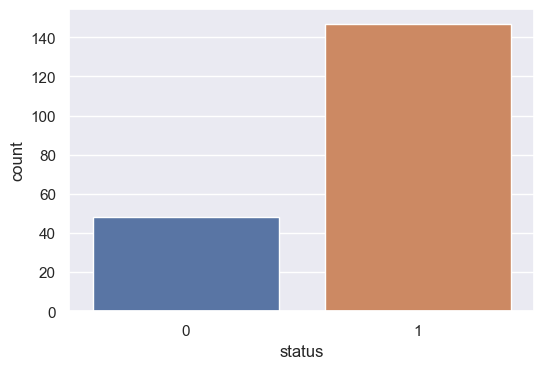

In [19]:
ax = sns.countplot(x="status", data=df)

Setup environment

In [39]:
#cls1 = setup(data = no_namedf, target = 'status', train_size = 0.7, fold_shuffle=True, session_id=123)
cls1 = setup(data = no_namedf, target = 'status', train_size = 0.7, fold_shuffle=True, session_id=123)

,Description,Value
0,session_id,123
1,Target,status
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(195, 15)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

Best Model

In [38]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8819,0.9252,0.9327,0.9192,0.9245,0.6411,0.6431,3.1880
et,Extra Trees Classifier,0.8753,0.9327,0.9427,0.9014,0.9203,0.6327,0.6462,0.1720
knn,K Neighbors Classifier,0.8610,0.8765,0.9527,0.8800,0.9128,0.5581,0.5755,0.0180
rf,Random Forest Classifier,0.8456,0.9103,0.9418,0.8726,0.9031,0.5142,0.5422,0.1500
lightgbm,Light Gradient Boosting Machine,0.8379,0.8795,0.9036,0.8880,0.8946,0.5354,0.5433,0.3190
xgboost,Extreme Gradient Boosting,0.8374,0.8877,0.8845,0.9032,0.8922,0.5504,0.5554,0.0630
ridge,Ridge Classifier,0.8236,0.0000,0.9427,0.8485,0.8895,0.4396,0.4798,0.0120
gbc,Gradient Boosting Classifier,0.8231,0.8817,0.8836,0.8950,0.8846,0.4974,0.5226,0.0560
lr,Logistic Regression,0.8088,0.7743,0.9236,0.8458,0.8796,0.4082,0.4434,1.4470
lda,Linear Discriminant Analysis,0.8016,0.8023,0.9136,0.8439,0.8745,0.3936,0.4189,0.0130


Create XGBoost Model & Tune 

In [40]:
cb = create_model('catboost')
#cb_tuned = tune_model(cb, n_iter = 50, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.7857,0.9091,0.9091,0.8333,0.8696,0.2759,0.2843
2,0.7857,0.8485,0.8182,0.9000,0.8571,0.4324,0.4404
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.8571,0.9000,0.9000,0.9000,0.9000,0.6500,0.6500
5,0.9286,0.9000,1.0000,0.9091,0.9524,0.8108,0.8257
6,0.8462,0.9667,0.9000,0.9000,0.9000,0.5667,0.5667
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.6923,0.7000,0.9000,0.7500,0.8182,-0.1304,-0.1581
9,0.9231,1.0000,0.9000,1.0000,0.9474,0.8060,0.8216


Create ET Model & Tune

Plot Model

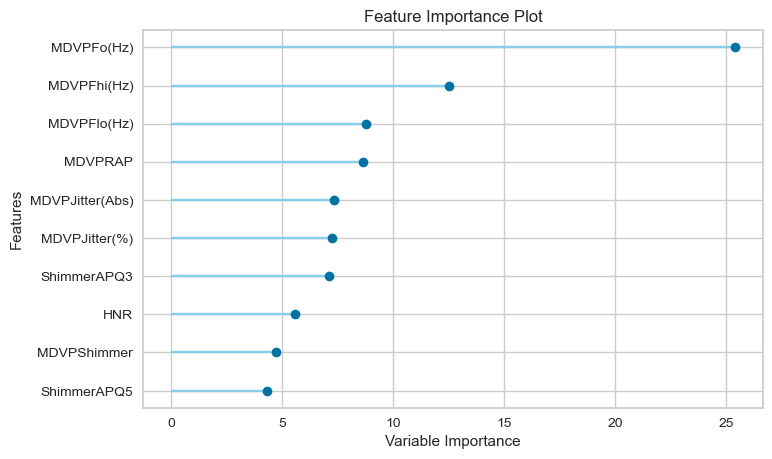

In [42]:
plot_model(cb, plot = 'feature')

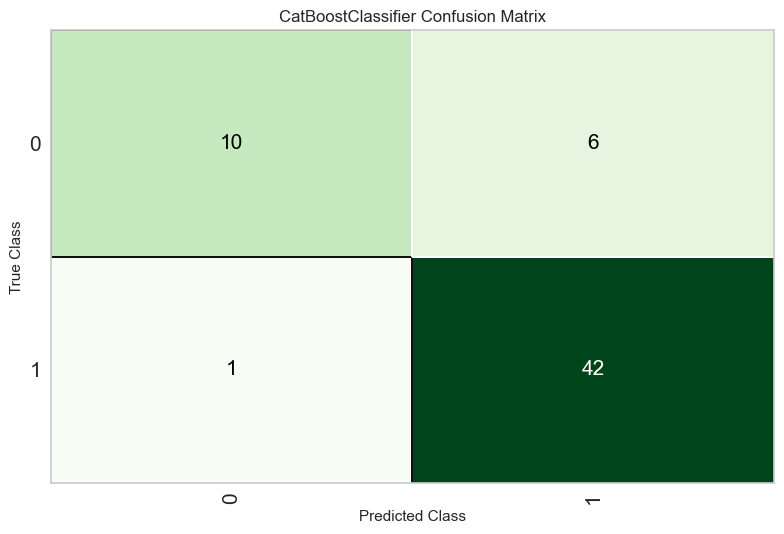

In [44]:
plot_model(cb, plot='confusion_matrix')

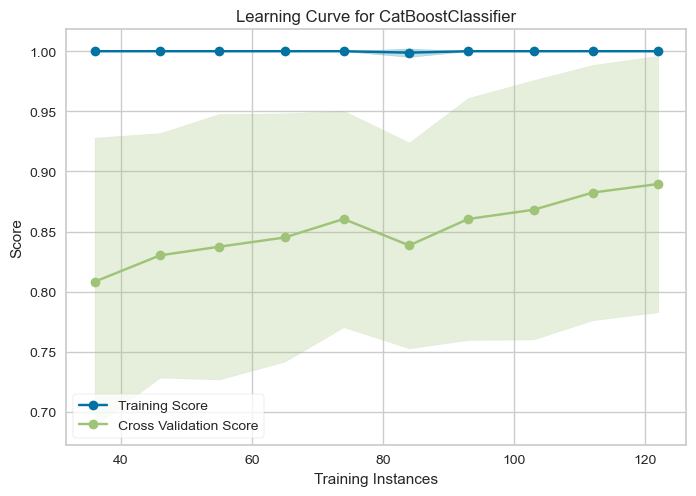

In [65]:
plot_model(cb, plot = 'learning', use_train_data = True)

**Test with my voice recording**

In [58]:
leo = pd.read_excel(r"C:\Users\loo\Downloads\voicelab_results (3).xlsx", sheet_name= "Summary edited")
#leo = leo.drop(["name", 'status'], axis='columns')
#cols =  ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']

new_data = pd.DataFrame(data=leo)
new_data
predict_model(cb, data = new_data)

,Input File,Voice Duration,Input File.1,MDVP:Fo(Hz),MDVP:Flo(Hz),MDVP:Fhi(Hz),HNR,MDVP:Jitter(%),Jitter:DDP,MDVP:Jitter(Abs),...,MDVP:PPQ,MDVP:Shimmer,local_shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:DDA,status,Label,Score
0,The Leopard IO copy,61.588,The Leopard IO copy,231.102013,95.50598,499.289842,9.839528,0.017236,0.021972,0.000075,...,0.008379,0.021972,0.104542,1.038772,0.038336,0.059801,0.115009,0,0,0.6167


In [53]:
interpret_model(cb, plot='reason', observation=32)

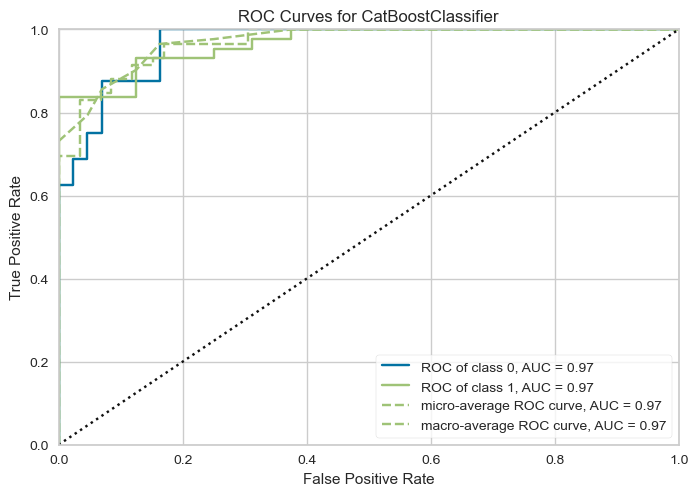

In [59]:
plot_model(cb, plot = 'auc')